In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn
from scipy import stats
from sklearn.preprocessing import MinMaxScaler


In [3]:
# Load dataset
radi = pd.read_csv("sbsppdaa24/train_radiomics_hipocamp.csv")

# Drop unique identifier columns
radi.drop(columns=["Mask", "ID", "Image"], inplace=True)

# Drop non-numeric columns except for 'Transition'
columns_to_drop = [col for col in radi.columns if radi[col].dtype == 'object' and col != 'Transition']
radi.drop(columns=columns_to_drop, inplace=True)
print(f"Dropped {len(columns_to_drop)} non-numeric columns.")

# Drop columns where all entries are the same
same_value_cols = [col for col in radi.columns if radi[col].nunique() == 1]
radi.drop(columns=same_value_cols, inplace=True)
print(f"Dropped {len(same_value_cols)} columns with the same value for every entry.")

# Apply MinMax scaling to float columns
float_cols = radi.select_dtypes(include=['float','int']).columns
scaler = MinMaxScaler()
radi[float_cols] = scaler.fit_transform(radi[float_cols])

# Check final dataset
radi.info()


Dropped 16 non-numeric columns.
Dropped 148 columns with the same value for every entry.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Columns: 2014 entries, diagnostics_Image-original_Mean to Transition
dtypes: float64(2013), object(1)
memory usage: 4.7+ MB


In [4]:
from sklearn.model_selection import train_test_split, GridSearchCV,StratifiedKFold
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, f1_score

# Estado vai ser comum para todos os modelos, 
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2025)
classification_reports = {}

## Bagging

In [5]:
# Split data into features and target
df = radi.copy()
X = df.drop(columns=["Transition"])
y = df["Transition"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2025)

bagging_params = {"n_estimators": [100, 500, 800, 1000]}
bagging_model = BaggingClassifier(random_state=2025)
bagging_grid = GridSearchCV(bagging_model, bagging_params, scoring='f1_weighted', cv=skf, n_jobs=-1)
bagging_grid.fit(X_train, y_train)
y_pred_bagging = bagging_grid.best_estimator_.predict(X_test)
classification_reports["Bagging"] = classification_report(y_test, y_pred_bagging, output_dict=True,zero_division=0)
print(f"Best Bagging Model Parameters: {bagging_grid.best_params_}")
print(f"Bagging Classification Report:\n", classification_report(y_test, y_pred_bagging))

Best Bagging Model Parameters: {'n_estimators': 800}
Bagging Classification Report:
               precision    recall  f1-score   support

       AD-AD       0.56      0.36      0.43        14
       CN-CN       0.51      0.69      0.59        26
      CN-MCI       0.00      0.00      0.00         1
      MCI-AD       0.35      0.50      0.41        14
     MCI-MCI       0.23      0.14      0.17        22

    accuracy                           0.43        77
   macro avg       0.33      0.34      0.32        77
weighted avg       0.40      0.43      0.40        77



/Users/nunorodrigues/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nunorodrigues/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nunorodrigues/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

## Random Forest

In [6]:
# Split data into features and target
df = radi.copy()
X = df.drop(columns=["Transition"])
y = df["Transition"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2025)

# Params Definition
rf_params = {"n_estimators": [100,300,500, 800, 1000], "max_depth": [5, 10, 20, None],"criterion" :["gini","entropy"]}
rf_model = RandomForestClassifier(random_state=2025)

# model, params, scoring using f1, 5 folds, full processor
rf_grid = GridSearchCV(rf_model, rf_params, scoring='f1_weighted', cv=skf, n_jobs=-1)
rf_grid.fit(X_train, y_train)

y_pred_rf = rf_grid.best_estimator_.predict(X_test)
classification_reports["RandomForest"] = classification_report(y_test, y_pred_rf, output_dict=True,zero_division=0)
print(f"Best RandomForest Model Parameters: {rf_grid.best_params_}")
print(f"RandomForest Classification Report:\n", classification_report(y_test, y_pred_rf))

Best RandomForest Model Parameters: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 500}
RandomForest Classification Report:
               precision    recall  f1-score   support

       AD-AD       0.56      0.36      0.43        14
       CN-CN       0.56      0.77      0.65        26
      CN-MCI       0.00      0.00      0.00         1
      MCI-AD       0.38      0.43      0.40        14
     MCI-MCI       0.44      0.32      0.37        22

    accuracy                           0.49        77
   macro avg       0.38      0.37      0.37        77
weighted avg       0.48      0.49      0.47        77



/Users/nunorodrigues/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nunorodrigues/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nunorodrigues/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

## Gradient Boosting

In [7]:
# Split data into features and target
df = radi.copy()
X = df.drop(columns=["Transition"]) 
y = df["Transition"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2025)

# Params Definition
gb_params = {"n_estimators": [500, 600, 1000], "learning_rate": [0.1, 0.3,0.01]}
gb_model = GradientBoostingClassifier(random_state=2025)

# model, params, scoring using f1, 5 folds, full processor
gb_grid = GridSearchCV(gb_model, gb_params, scoring='f1_weighted',cv=skf, n_jobs=-1)
gb_grid.fit(X_train, y_train)

y_pred_gb = gb_grid.best_estimator_.predict(X_test)
classification_reports["GradientBoosting"] = classification_report(y_test, y_pred_gb, output_dict=True,zero_division=0)
print(f"Best GradientBoosting Model Parameters: {gb_grid.best_params_}")
print(f"GradientBoosting Classification Report:\n", classification_report(y_test, y_pred_gb))


Best GradientBoosting Model Parameters: {'learning_rate': 0.1, 'n_estimators': 500}
GradientBoosting Classification Report:
               precision    recall  f1-score   support

       AD-AD       0.33      0.29      0.31        14
       CN-CN       0.67      0.62      0.64        26
      CN-MCI       0.00      0.00      0.00         1
      MCI-AD       0.25      0.29      0.27        14
     MCI-MCI       0.35      0.32      0.33        22

    accuracy                           0.40        77
   macro avg       0.32      0.30      0.31        77
weighted avg       0.43      0.40      0.42        77



## XGBoosting

In [8]:
from sklearn.preprocessing import LabelEncoder

# Copy the dataframe and apply label encoding to the target variable
df = radi.copy()
label_encoder = LabelEncoder()
df['Transition'] = label_encoder.fit_transform(df['Transition'])

# Define features and target
X = df.drop(columns=["Transition"])
y = df["Transition"]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2025)

# Define XGBoost hyperparameters and model with a multi-class objective and compatible eval_metric
xgb_params = {
    "n_estimators": [500,800,600],
    "learning_rate": [0.1,0.3],
    "max_depth": [5,6,8,20],
    
}

xgb_model = XGBClassifier(eval_metric='mlogloss',random_state=2025)

# Run GridSearchCV to find the best parameters
xgb_grid = GridSearchCV(xgb_model, xgb_params, scoring='f1_weighted', cv=skf, n_jobs=-1)
xgb_grid.fit(X_train, y_train)

# Predict and evaluate
y_pred_xgb = xgb_grid.best_estimator_.predict(X_test)
classification_reports["XGBoost"] = classification_report(y_test, y_pred_xgb, output_dict=True,zero_division=0)
print(f"Best XGBoost Model Parameters: {xgb_grid.best_params_}")
print(f"XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))


Best XGBoost Model Parameters: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 500}
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.43      0.50        14
           1       0.50      0.73      0.59        26
           2       0.00      0.00      0.00         1
           3       0.29      0.29      0.29        14
           4       0.27      0.18      0.22        22

    accuracy                           0.43        77
   macro avg       0.33      0.33      0.32        77
weighted avg       0.41      0.43      0.41        77



/Users/nunorodrigues/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nunorodrigues/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nunorodrigues/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

## SVM

In [9]:
from sklearn.svm import SVC

df = radi.copy()
X = df.drop(columns=["Transition"]) 
y = df["Transition"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2025)

# Define the parameter grid for SVC
param_grid = {
    'C': [0.1, 1, 10, 100],              # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],  # Kernel types
    'gamma': ['scale', 'auto'],           # Kernel coefficient for 'rbf' and 'poly' kernels
}

# Initialize the SVC model
svm_model = SVC(random_state=2025)

# Initialize GridSearchCV with cross-validation
svm_grid = GridSearchCV(estimator=svm_model, param_grid=param_grid, 
                           cv=5, scoring='f1_weighted', verbose=1, n_jobs=-1)

svm_grid.fit(X_train, y_train)
y_pred_svm = svm_grid.best_estimator_.predict(X_test)
classification_reports["SVM"] = classification_report(y_test, y_pred_svm, output_dict=True,zero_division=0)
print(f"Best SVM Model Parameters: {svm_grid.best_params_}")
print(f"SVM Classification Report:\n", classification_report(y_test, y_pred_svm))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best SVM Model Parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
SVM Classification Report:
               precision    recall  f1-score   support

       AD-AD       0.62      0.36      0.45        14
       CN-CN       0.51      0.85      0.64        26
      CN-MCI       0.00      0.00      0.00         1
      MCI-AD       0.33      0.43      0.38        14
     MCI-MCI       0.38      0.14      0.20        22

    accuracy                           0.47        77
   macro avg       0.37      0.35      0.33        77
weighted avg       0.45      0.47      0.42        77



/Users/nunorodrigues/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nunorodrigues/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nunorodrigues/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

## Stacking

In [10]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

df = radi.copy()
X = df.drop(columns=["Transition"]) 
y = df["Transition"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2025)

meta_model = RandomForestClassifier(random_state=2025)

estimators = [("gb", gb_grid.best_estimator_), ("svm", svm_grid.best_estimator_), ("rf", rf_grid.best_estimator_)]
st_model = StackingClassifier(estimators=estimators, final_estimator = meta_model) 
st_model.fit(X_train, y_train)
st_predictions = st_model.predict(X_test)
classification_reports["Stacking"] = classification_report(y_test, st_predictions, output_dict=True,zero_division=0)
print(f"Stacking Classification Report:\n", classification_report(y_test, st_predictions))

Stacking Classification Report:
               precision    recall  f1-score   support

       AD-AD       0.36      0.29      0.32        14
       CN-CN       0.59      0.77      0.67        26
      CN-MCI       0.00      0.00      0.00         1
      MCI-AD       0.42      0.57      0.48        14
     MCI-MCI       0.46      0.27      0.34        22

    accuracy                           0.49        77
   macro avg       0.37      0.38      0.36        77
weighted avg       0.47      0.49      0.47        77



/Users/nunorodrigues/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nunorodrigues/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nunorodrigues/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

## Max Voting

In [11]:
from sklearn.ensemble import VotingClassifier

df = radi.copy()
X = df.drop(columns=["Transition"]) 
y = df["Transition"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2025)

estimators = [("gb", gb_grid.best_estimator_), ("svm", svm_grid.best_estimator_), ("rf", rf_grid.best_estimator_)]
vt_model = VotingClassifier(estimators=estimators, voting = 'hard', weights = [3,2,1]) 
vt_model.fit(X_train, y_train)
vt_predictions = vt_model.predict(X_test)
classification_reports["Voting"] = classification_report(y_test, vt_predictions, output_dict=True,zero_division=0)
print(f"Voting Classification Report:\n", classification_report(y_test, st_predictions))

Voting Classification Report:
               precision    recall  f1-score   support

       AD-AD       0.36      0.29      0.32        14
       CN-CN       0.59      0.77      0.67        26
      CN-MCI       0.00      0.00      0.00         1
      MCI-AD       0.42      0.57      0.48        14
     MCI-MCI       0.46      0.27      0.34        22

    accuracy                           0.49        77
   macro avg       0.37      0.38      0.36        77
weighted avg       0.47      0.49      0.47        77



/Users/nunorodrigues/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nunorodrigues/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nunorodrigues/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

## Ver Resultados

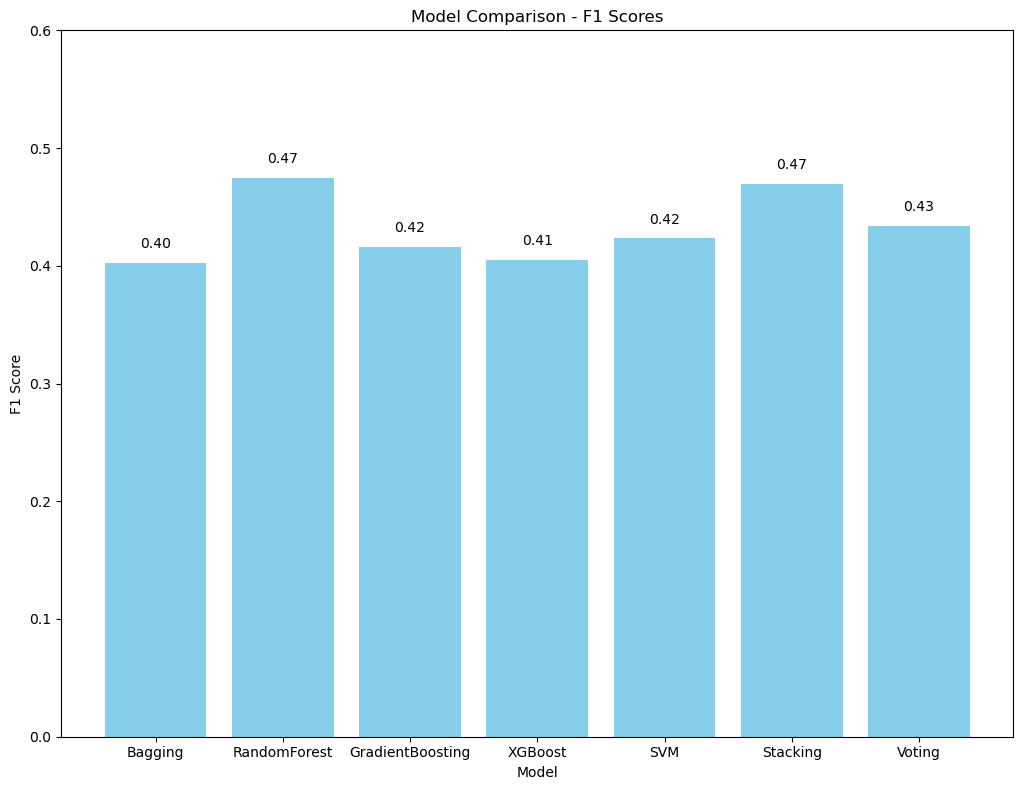

In [12]:
import matplotlib.pyplot as plt

# Assuming f1_scores is already defined
f1_scores = {model: report["weighted avg"]["f1-score"] for model, report in classification_reports.items()}

# Plotting
plt.figure(figsize=(20, 8))

# F1 Score Graph
plt.subplot(1, 2, 1)
bars = plt.bar(f1_scores.keys(), f1_scores.values(), color='skyblue')
plt.xlabel("Model")
plt.ylabel("F1 Score")
plt.title("Model Comparison - F1 Scores")
plt.ylim(0, 0.6)

# Display values on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


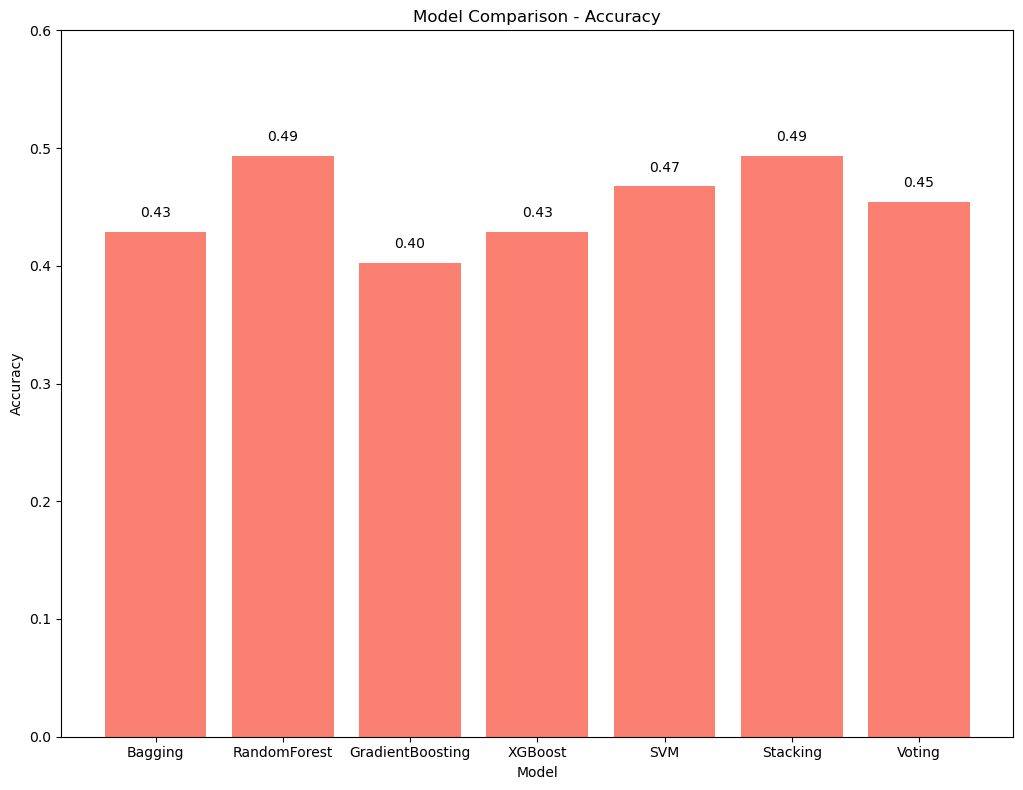

In [13]:
accuracies = {model: report["accuracy"] for model, report in classification_reports.items()}

# Accuracy Graph
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 2)
bars = plt.bar(accuracies.keys(), accuracies.values(), color='salmon')
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Model Comparison - Accuracy")
plt.ylim(0, 0.6)


# Display values on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## Generating csv

In [19]:
# Load the test dataset
test_data = pd.read_csv("sbsppdaa24/test_radiomics_hipocamp.csv")

# Apply the same preprocessing as in the training phase
# Drop unused columns to match the training features
test_data = test_data[radi.drop(["Transition"],axis=1).columns]

# Apply the previously fitted scaler to the test data
test_data[float_cols] = scaler.transform(test_data[float_cols])

# Generate predictions using the Bagging model
bg_predictions_test = bagging_grid.best_estimator_.predict(test_data)

# Generate predictions using the RandomForest model
rf_predictions_test = rf_grid.best_estimator_.predict(test_data)

# Generate predictions using the Gradient Boosting model
gb_predictions_test = gb_grid.best_estimator_.predict(test_data)

# Generate predictions using the Voting model
vb_predictions_test = vt_model.predict(test_data)

# Store each model's predictions in separate DataFrames and save to CSV
res0 = pd.DataFrame({
    'RowId': range(1, len(bg_predictions_test) + 1),
    'Result': bg_predictions_test 
})
res0.to_csv('BaggingGrid3.0.csv', index=False)

res1 = pd.DataFrame({
    'RowId': range(1, len(rf_predictions_test) + 1),
    'Result': rf_predictions_test
})
res1.to_csv('RandomForestGrid3.0.csv', index=False)

res2 = pd.DataFrame({
    'RowId': range(1, len(gb_predictions_test) + 1),
    'Result': gb_predictions_test
})
res2.to_csv('GradientBoostingGrid3.0.csv', index=False)

res3 = pd.DataFrame({
    'RowId': range(1, len(vb_predictions_test) + 1),
    'Result': vb_predictions_test
})
res3.to_csv('Voting3.0.csv', index=False)


# Full Data Models ( The ones I found relevant ) 

In [15]:
# Split data into features and target
df = radi.copy()
X = df.drop(columns=["Transition"])
y = df["Transition"]


# Best RandomForest Model Parameters: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 500}
# Params Definition
rfinal_model = RandomForestClassifier(criterion="gini", max_depth=10, n_estimators=500, random_state=2025)

rfinal_model.fit(X,y)


# Load the test dataset
test_data = pd.read_csv("sbsppdaa24/test_radiomics_hipocamp.csv")

# Apply the same preprocessing as in the training phase
# Drop unused columns to match the training features
test_data = test_data[radi.drop(["Transition"],axis=1).columns]

# Apply the previously fitted scaler to the test data
test_data[float_cols] = scaler.transform(test_data[float_cols])


y_rdf_pred = rfinal_model.predict(test_data)


res0f = pd.DataFrame({
    'RowId': range(1, len(y_rdf_pred) + 1),
    'Result': y_rdf_pred 
})
res0f.to_csv('RandomForrestFullData3.0.csv', index=False)


In [17]:
# Split data into features and target
df = radi.copy()
X = df.drop(columns=["Transition"])
y = df["Transition"]

meta_model = RandomForestClassifier(random_state=2025)

estimators = [("gb", gb_grid.best_estimator_), ("svm", svm_grid.best_estimator_), ("rf", rf_grid.best_estimator_)]
stf_model = StackingClassifier(estimators=estimators, final_estimator = meta_model) 
stf_model.fit(X, y)
stf_predictions = stf_model.predict(X_test)



# Load the test dataset
test_data = pd.read_csv("sbsppdaa24/test_radiomics_hipocamp.csv")

# Apply the same preprocessing as in the training phase
# Drop unused columns to match the training features
test_data = test_data[radi.drop(["Transition"],axis=1).columns]

# Apply the previously fitted scaler to the test data
test_data[float_cols] = scaler.transform(test_data[float_cols])


y_stf_pred = stf_model.predict(test_data)


res1f = pd.DataFrame({
    'RowId': range(1, len(y_stf_pred) + 1),
    'Result':y_stf_pred
})
res1f.to_csv('StackingFullData3.0.csv', index=False)
